In [1]:
Threads.nthreads()

8

In [2]:
using DifferentialEquations, Plots, LaTeXStrings

In [3]:
const Φ₀ = 2.06783383e-15
const ħ = 1.0545718e-34
const Ic = 1.69e-9;

# Capacitively Coupled Parallel RLC Circuit

Kirchoff's voltage law gives us, for each closed loop around the circuit

$$ V(t) = \frac{Q}{C_{CL}} + L \dot{I}_L $$

$$ V(t) = \frac{Q}{C_{CL}} + I_R $$

$$ V(t) = \frac{Q}{C_{CL}} + L \frac{Q_C}{C} $$

Relating these equations gives

$$ L\dot{I}_L = I_R R $$

$$ L\dot{I}_L = \frac{Q_C}{C} $$

Then using Kirchoff's current law, $I = I_C + I_R + I_L$, along with the fact that $I = \frac{dQ}{dt}$  and $ I_C = \frac{dQ_C}{dt}$, we get a second order differential equation for the current in the inductive element

$$ \ddot{I}_L = \frac{-1}{C_c + C}\left(\frac{1}{R} \dot{I}_L + \frac{1}{L} I_L\right) + \frac{\omega V_0 \cos(\omega t)}{L\left(1 + \frac{C}{C_c}\right)} $$

## RLC Model Parameters

In [4]:
const V₀ = 1.0e-3
const Q = 1000.0
const Cc = 0.1e-15
const Cs = 56e-15
const CJ = 7e-15
const C = Cs + CJ
const L = Φ₀ / (2π * Ic);

parallel resistance:

In [5]:
R = Q / sqrt(C / L)

1.758143246919784e6

rosonance frequency:

In [6]:
ω₀ = 1 / sqrt(L * C)

9.028283617290537e9

## Problem Setup

In [7]:
function RLC(ddI, dI, I, ω, t)
    @. ddI = -1 / (Cc + C) * (1 / R * dI + 1 / L * I) + ω * V₀ * cos(ω * t) / (L * (1 + C / Cc))
end;

problem parameters:

In [98]:
tspan = (0.0, 5e-9)
dt = 1e-11;

algorithm:

In [99]:
alg = VerletLeapfrog();

## Demo Solution

In [100]:
driving_frequency = 9e9;

In [101]:
prob = SecondOrderODEProblem(RLC, [0.0], [0.0], tspan, driving_frequency);

In [102]:
sol = solve(prob, alg, dt=dt);

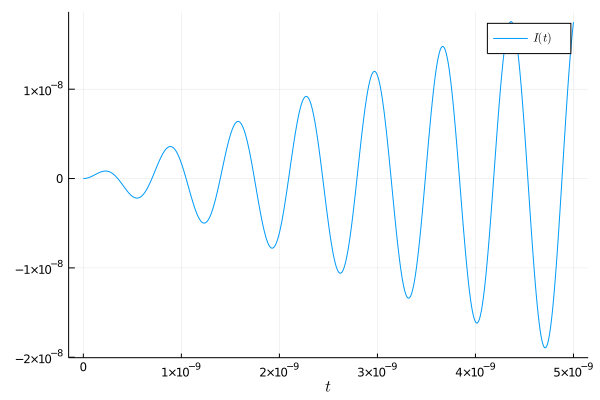

In [103]:
plot(sol.t, sol[2,:], label=L"I(t)", xlabel=L"t")
# plot!(sol.t, sol[1,:], label=L"dI/dt")
# plot!(sol.t, sin.(driving_frequency .* sol.t), label="driving voltage")

## Resonance Sweep

In [107]:
sweeprange = 2e10
ωs = collect(0:1e7:sweeprange);

In [108]:
peaks = Vector{Float64}(undef, length(ωs))
Threads.@threads for i in 1:length(ωs)
    problem = SecondOrderODEProblem(RLC, [0.0], [0.0], tspan, ωs[i])
    solution = solve(problem, alg, dt=dt)
    peaks[i] = maximum(solution[2,:])
end

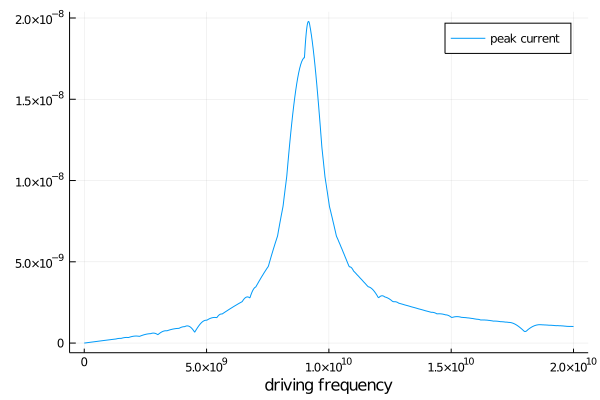

In [109]:
plot(ωs, peaks, label="peak current", xlabel="driving frequency")

# Qubit Circuit

By replacing the inductor in the RLC circuit with a Josephson Junction, we get a time-dependent inductance defined as

$$L_J (I_J(t)) = \frac{\Phi_0}{2\pi \sqrt{I_c^2- I_J^2(t)}}$$

Which gives us the following differential equation for the current, $I_J$, in the Josephson Junction

$$\ddot{I}_J = \frac{-1}{C_{CL} + C_{s + J}} \left(\frac{1}{R} \dot{I}_J + \frac{1}{L_J} I_J \right) - \frac{I_J}{I_c^2 - I_J^2} \dot{I}_J^2 + \frac{\omega V_0 \cos(\omega t)}{L_J\left(1 + \frac{C_{s + J}}{C_{CL}}\right)}   $$
          

## Parameters

In [110]:
const Cg = 5.0e-15
const CΣ = Cs + CJ + Cg
const Rn = 14.0e-3
const qubitV₀ = 1.0;

In [111]:
qubit_Q = 1e6
qubit_R = Q / sqrt(C / L)

1.758143246919784e6

## Problem Setup

In [112]:
function qubit(ddI::Vector{Complex{Float64}}, 
               dI::Vector{Complex{Float64}}, 
               I::Vector{Complex{Float64}}, 
               ω, t)
    @. ddI = -1 / (Cc + C) * 
             (1 / R * dI + 1 / (Φ₀ / (2π * sqrt(Complex(Ic^2 - I^2)))) * I) - 
             I / (Ic^2 - I^2) * dI^2 + 
             ω * V₀ * cos(ω * t) / 
             ((Φ₀ / (2π * sqrt(Complex(Ic^2 - I^2)))) * (1 + C / Cc))
end;

In [134]:
qubit_ωs = collect(0:1e8:5e11)
qubit_peaks = Vector{Float64}(undef, length(qubit_ωs))
qubit_alg = VerletLeapfrog();

In [135]:
tspan = (0.0, 1e-10)
dt = 2e-14

2.0e-14

## Solutions

In [136]:
Threads.@threads for i in 1:length(qubit_ωs)
    problem = SecondOrderODEProblem(qubit, Complex.([0.0]), Complex.([0.0]), tspan, qubit_ωs[i])
    solution = solve(problem, alg, dt=dt, reltol=1e-9, abstol=1e-9)
    qubit_peaks[i] = maximum(abs.(solution[2,:]))
end

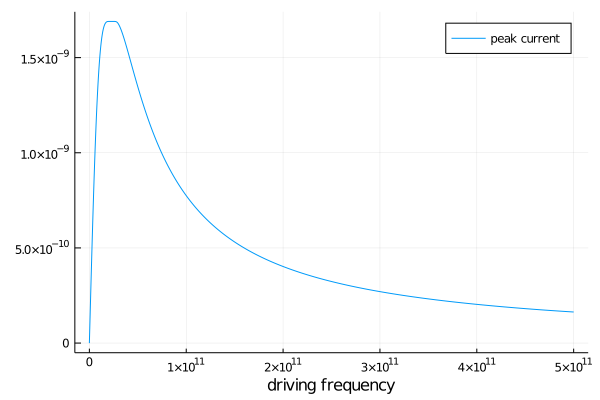

In [137]:
plot(qubit_ωs, qubit_peaks, label="peak current", xlabel="driving frequency")

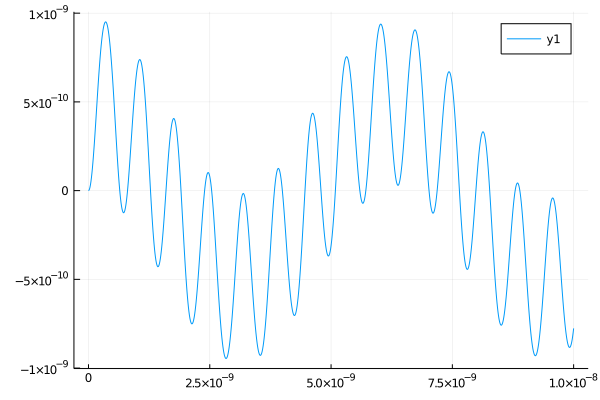

In [138]:
tspan = (0.0, 1e-8)
qubit_prob = SecondOrderODEProblem(qubit, [0.0 + 0.0im], [0.0 + 0.0im], tspan, 1e9)
qubit_sol = solve(qubit_prob, alg, dt=1e-11, reltol=1e-9, abstol=1e-9)
plot(qubit_sol.t, real.(qubit_sol[2,:]))

In [139]:
qubit_ωs[argmax(qubit_peaks)]

1.99e10